Derajat Salim Wibowo
221011077
S1 Informatika
UPN Veteran Jakarta

https://www.kaggle.com/datasets/ibrahimkaratas/gtsrb-german-traffic-sign-recognition-benchmark

In [1]:
!pip install -q kaggle

In [2]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"derajatsalimwibowo","key":"b31f7d61483acc1fdad2c62a4c22e8cc"}'}

In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d ibrahimkaratas/gtsrb-german-traffic-sign-recognition-benchmark

 96% 221M/231M [00:02<00:00, 116MB/s]
100% 231M/231M [00:02<00:00, 116MB/s]


In [5]:
!unzip -qq gtsrb-german-traffic-sign-recognition-benchmark.zip

In [55]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pathlib, os, random, shutil
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, Dropout
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img, load_img
from tensorflow.keras import Sequential
from tensorflow.keras.utils import to_categorical

In [56]:
train_dir = "/content/Train"

In [57]:
# Fungsi untuk memeriksa ukuran gambar dalam suatu direktori
def check_image_size(folder_path):
    sizes = []
    for category in os.listdir(folder_path):
        category_path = os.path.join(folder_path, category)
        for file in os.listdir(category_path):
            file_path = os.path.join(category_path, file)
            image = plt.imread(file_path)
            sizes.append(image.shape)
    return pd.Series(sizes).value_counts()

print("Ukuran gambar dalam dataset train:")
train_image_sizes = check_image_size(train_dir)
print(train_image_sizes)


Ukuran gambar dalam dataset train:
(31, 31, 3)    396
(30, 30, 3)    380
(35, 35, 3)    360
(32, 32, 3)    352
(33, 33, 3)    351
              ... 
(79, 59, 3)      1
(97, 70, 3)      1
(99, 63, 3)      1
(83, 60, 3)      1
(55, 65, 3)      1
Length: 2924, dtype: int64


In [58]:
img_height = 30
img_width = 30
channels = 3
num_categories = len(os.listdir(train_dir))
num_categories

43

In [59]:
# Label Overview
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)',
            2:'Speed limit (50km/h)',
            3:'Speed limit (60km/h)',
            4:'Speed limit (70km/h)',
            5:'Speed limit (80km/h)',
            6:'End of speed limit (80km/h)',
            7:'Speed limit (100km/h)',
            8:'Speed limit (120km/h)',
            9:'No passing',
            10:'No passing veh over 3.5 tons',
            11:'Right-of-way at intersection',
            12:'Priority road',
            13:'Yield',
            14:'Stop',
            15:'No vehicles',
            16:'Veh > 3.5 tons prohibited',
            17:'No entry',
            18:'General caution',
            19:'Dangerous curve left',
            20:'Dangerous curve right',
            21:'Double curve',
            22:'Bumpy road',
            23:'Slippery road',
            24:'Road narrows on the right',
            25:'Road work',
            26:'Traffic signals',
            27:'Pedestrians',
            28:'Children crossing',
            29:'Bicycles crossing',
            30:'Beware of ice/snow',
            31:'Wild animals crossing',
            32:'End speed + passing limits',
            33:'Turn right ahead',
            34:'Turn left ahead',
            35:'Ahead only',
            36:'Go straight or right',
            37:'Go straight or left',
            38:'Keep right',
            39:'Keep left',
            40:'Roundabout mandatory',
            41:'End of no passing',
            42:'End no passing veh > 3.5 tons' }

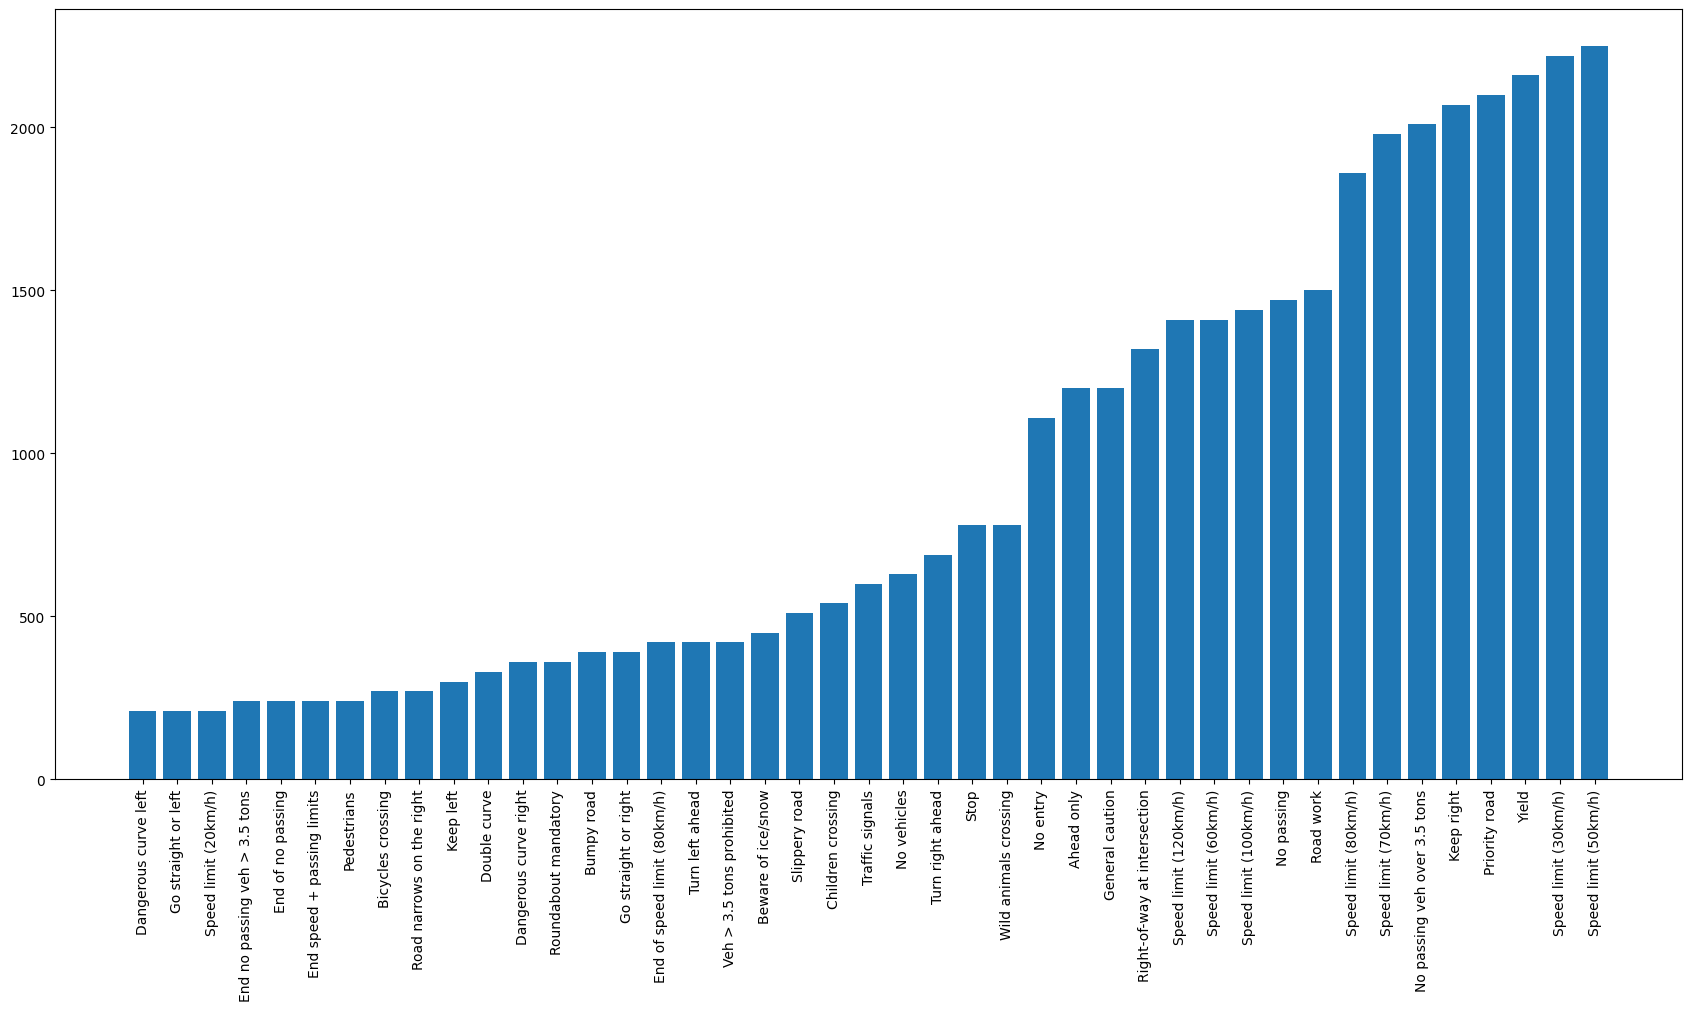

In [60]:
folders = os.listdir(train_dir)

train_number = []
class_num = []

for folder in folders:
    train_files = os.listdir(train_dir + '/' + folder)
    train_number.append(len(train_files))
    class_num.append(classes[int(folder)])

zipped_lists = zip(train_number, class_num)
sorted_pairs = sorted(zipped_lists)
tuples = zip(*sorted_pairs)
train_number, class_num = [ list(tuple) for tuple in  tuples]

plt.figure(figsize=(21,10))
plt.bar(class_num, train_number)
plt.xticks(class_num, rotation='vertical')
plt.show()

In [61]:
def load_data(data_dir):

    images = list()
    labels = list()
    for category in range(num_categories):
        categories = os.path.join(data_dir, str(category))
        for img in os.listdir(categories):
            img = load_img(os.path.join(categories, img), target_size=(30, 30))
            image = img_to_array(img)
            images.append(image)
            labels.append(category)

    return images, labels

In [62]:
images, labels = load_data(train_dir)
labels = to_categorical(labels)

#Membagi dataset train menjadi 20%nya untuk test
x_train, x_test, y_train, y_test = train_test_split(
                                                    np.array(images),
                                                    labels,
                                                    test_size=0.2 ,
                                                    random_state=42,
                                                    shuffle=True
                                                    )

In [50]:
print("x_train.shape", x_train.shape)
print("x_valid.shape", x_test.shape)
print("y_train.shape", y_train.shape)
print("y_valid.shape", y_test.shape)

x_train.shape (31367, 30, 30, 3)
x_valid.shape (7842, 30, 30, 3)
y_train.shape (31367, 43)
y_valid.shape (7842, 43)


In [63]:
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=(3,3), activation="relu", input_shape=(img_height,img_width,3)))
model.add(Conv2D(filters=32, kernel_size=(3,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(rate=0.25))
model.add(Conv2D(filters=64, kernel_size=(3,3), activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(rate=0.25))
model.add(Flatten())
model.add(Dense(512, activation="relu"))
model.add(Dropout(rate=0.5))
model.add(Dense(43, activation="softmax"))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 28, 28, 16)        448       
                                                                 
 conv2d_17 (Conv2D)          (None, 26, 26, 32)        4640      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 dropout_12 (Dropout)        (None, 13, 13, 32)        0         
                                                                 
 conv2d_18 (Conv2D)          (None, 11, 11, 64)        18496     
                                                                 
 conv2d_19 (Conv2D)          (None, 9, 9, 128)         73856     
                                                      

In [64]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.92 and logs.get('val_accuracy')>0.92):
      print("\nAkurasi train dan validasi didapat telah mencapai nilai > 92%!")
      self.model.stop_training = True

callbacks = myCallback()

In [67]:
history= model.fit(x_train,y_train,
                 epochs=15,
                 batch_size=64,
                 validation_data=(x_test,y_test),
                 callbacks = [callbacks])

Epoch 1/15
491/491 [==============================] - 121s 245ms/step - loss: 0.9121 - accuracy: 0.7562 - val_loss: 0.1569 - val_accuracy: 0.9589
Epoch 2/15
490/491 [============================>.] - ETA: 0s - loss: 0.2667 - accuracy: 0.9265
Akurasi train dan validasi didapat telah mencapai nilai > 92%!
491/491 [==============================] - 114s 233ms/step - loss: 0.2667 - accuracy: 0.9265 - val_loss: 0.0944 - val_accuracy: 0.9784


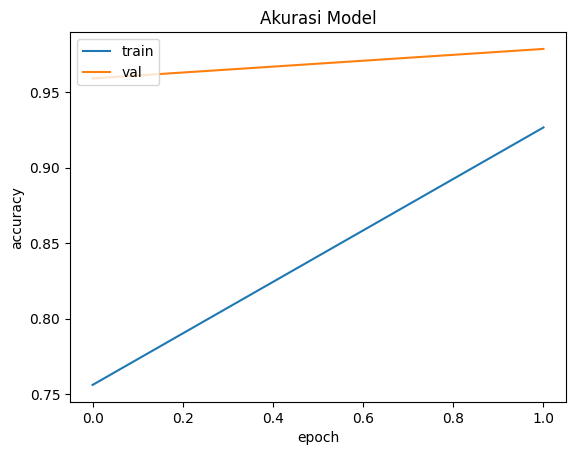

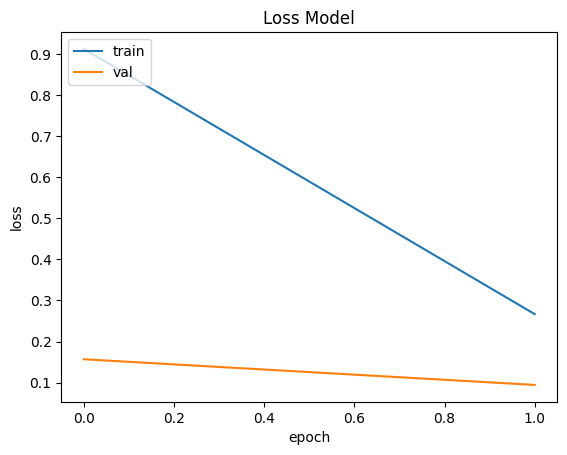

In [68]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Akurasi Model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [69]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)